In [68]:
#| hide
import sys
sys.path.append('../.venv/lib/python3.9/site-packages/')
sys.path

['/afs/crc.nd.edu/group/TAI/Users/painswor/Explain2Me-Framework-Example/nbs',
 '/opt/anaconda3/lib/python39.zip',
 '/opt/anaconda3/lib/python3.9',
 '/opt/anaconda3/lib/python3.9/lib-dynload',
 '',
 '/afs/crc.nd.edu/user/p/painswor/.local/lib/python3.9/site-packages',
 '/opt/anaconda3/lib/python3.9/site-packages',
 '/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions',
 '/afs/crc.nd.edu/user/p/painswor/.ipython',
 '../.venv/lib/python3.9/site-packages/',
 '../.venv/lib/python3.9/site-packages/']

# Running Model

In [3]:
import torch
import transformers

2023-03-06 12:26:41.508353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print(transformers)

<module 'transformers' from '/afs/crc.nd.edu/group/TAI/Users/painswor/Explain2Me-Framework-Example/nbs/../.venv/lib/python3.9/site-packages/transformers/__init__.py'>


## Necessary Arguments

In [11]:
model_path = "../Models/weights/Densenet/densenet_cyborg_1/Logs/final_model.pth"
device = torch.device('cpu')
network = "densenet"

## Loading the Model

In [19]:
import torchvision.models as models
import torch.nn as nn

First, load in the weights

In [15]:
weights = torch.load(model_path, map_location=device)

Now, load weights on a single binary DesNet121 model

In [20]:
if network == "resnet":
    im_size = 224
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
elif network == "inception":
    im_size = 299
    model = models.inception_v3(pretrained=True,aux_logits=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
elif network == "xception":
    im_size = 299
    model, *_ = model_selection(modelname='xception', num_out_classes=2)
else: # else DenseNet
    im_size = 224
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 2)

In [21]:
target_layers = [model.features[-1]]
model.load_state_dict(weights['state_dict'])
model = model.to(device)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Preprocessing

In [27]:
import torchvision.transforms as transforms

In [26]:
if network == "xception":
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize([0.5]*3, [0.5]*3)
            ])
else:
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

In [28]:
imageScores = []
sigmoid = nn.Sigmoid()

## Creating GradCam

In [40]:
from PIL import Image
from torchcam.methods import GradCAM
from torchcam.methods import GradCAMpp

Laod the image

In [41]:
gradcamType = "gradcam"
img_path = "../Data/images/ffhq_aligned/00001.png"

In [42]:
image = Image.open(img_path).convert('RGB')

Input transformation

In [43]:
input_tensor = transform(image)
image.close()

Generate GradCAM

In [44]:
if gradcamType == "gradcam":
    #cam_extractor = GradCAM(model, target_layers)
    cam_extractor = GradCAM(model)
elif gradcamType == "gradcamPP":
    cam_extractor = GradCAMpp(model, target_layers)

## Processing GradCAM

In [50]:
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.utils import overlay_mask

Preprocess your data and feed it to the model

In [55]:
size = "upscaled"

In [45]:
out = model(input_tensor.unsqueeze(0))

Retrieve the CAM by passing class index and model output

In [46]:
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

In [56]:
cam = to_pil_image(activation_map[0].squeeze(0)).convert('RGB')
cam = overlay_mask(to_pil_image(input_tensor), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.50)
if size == 'upscaled':
    cam = cam.resize((im_size, im_size), resample = Image.BICUBIC)

/tmp/ipykernel_1974992/1378780251.py:4: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  cam = cam.resize((im_size, im_size), resample = Image.BICUBIC)


## Display GradCAM

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

/tmp/ipykernel_1974992/4078110203.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=None)


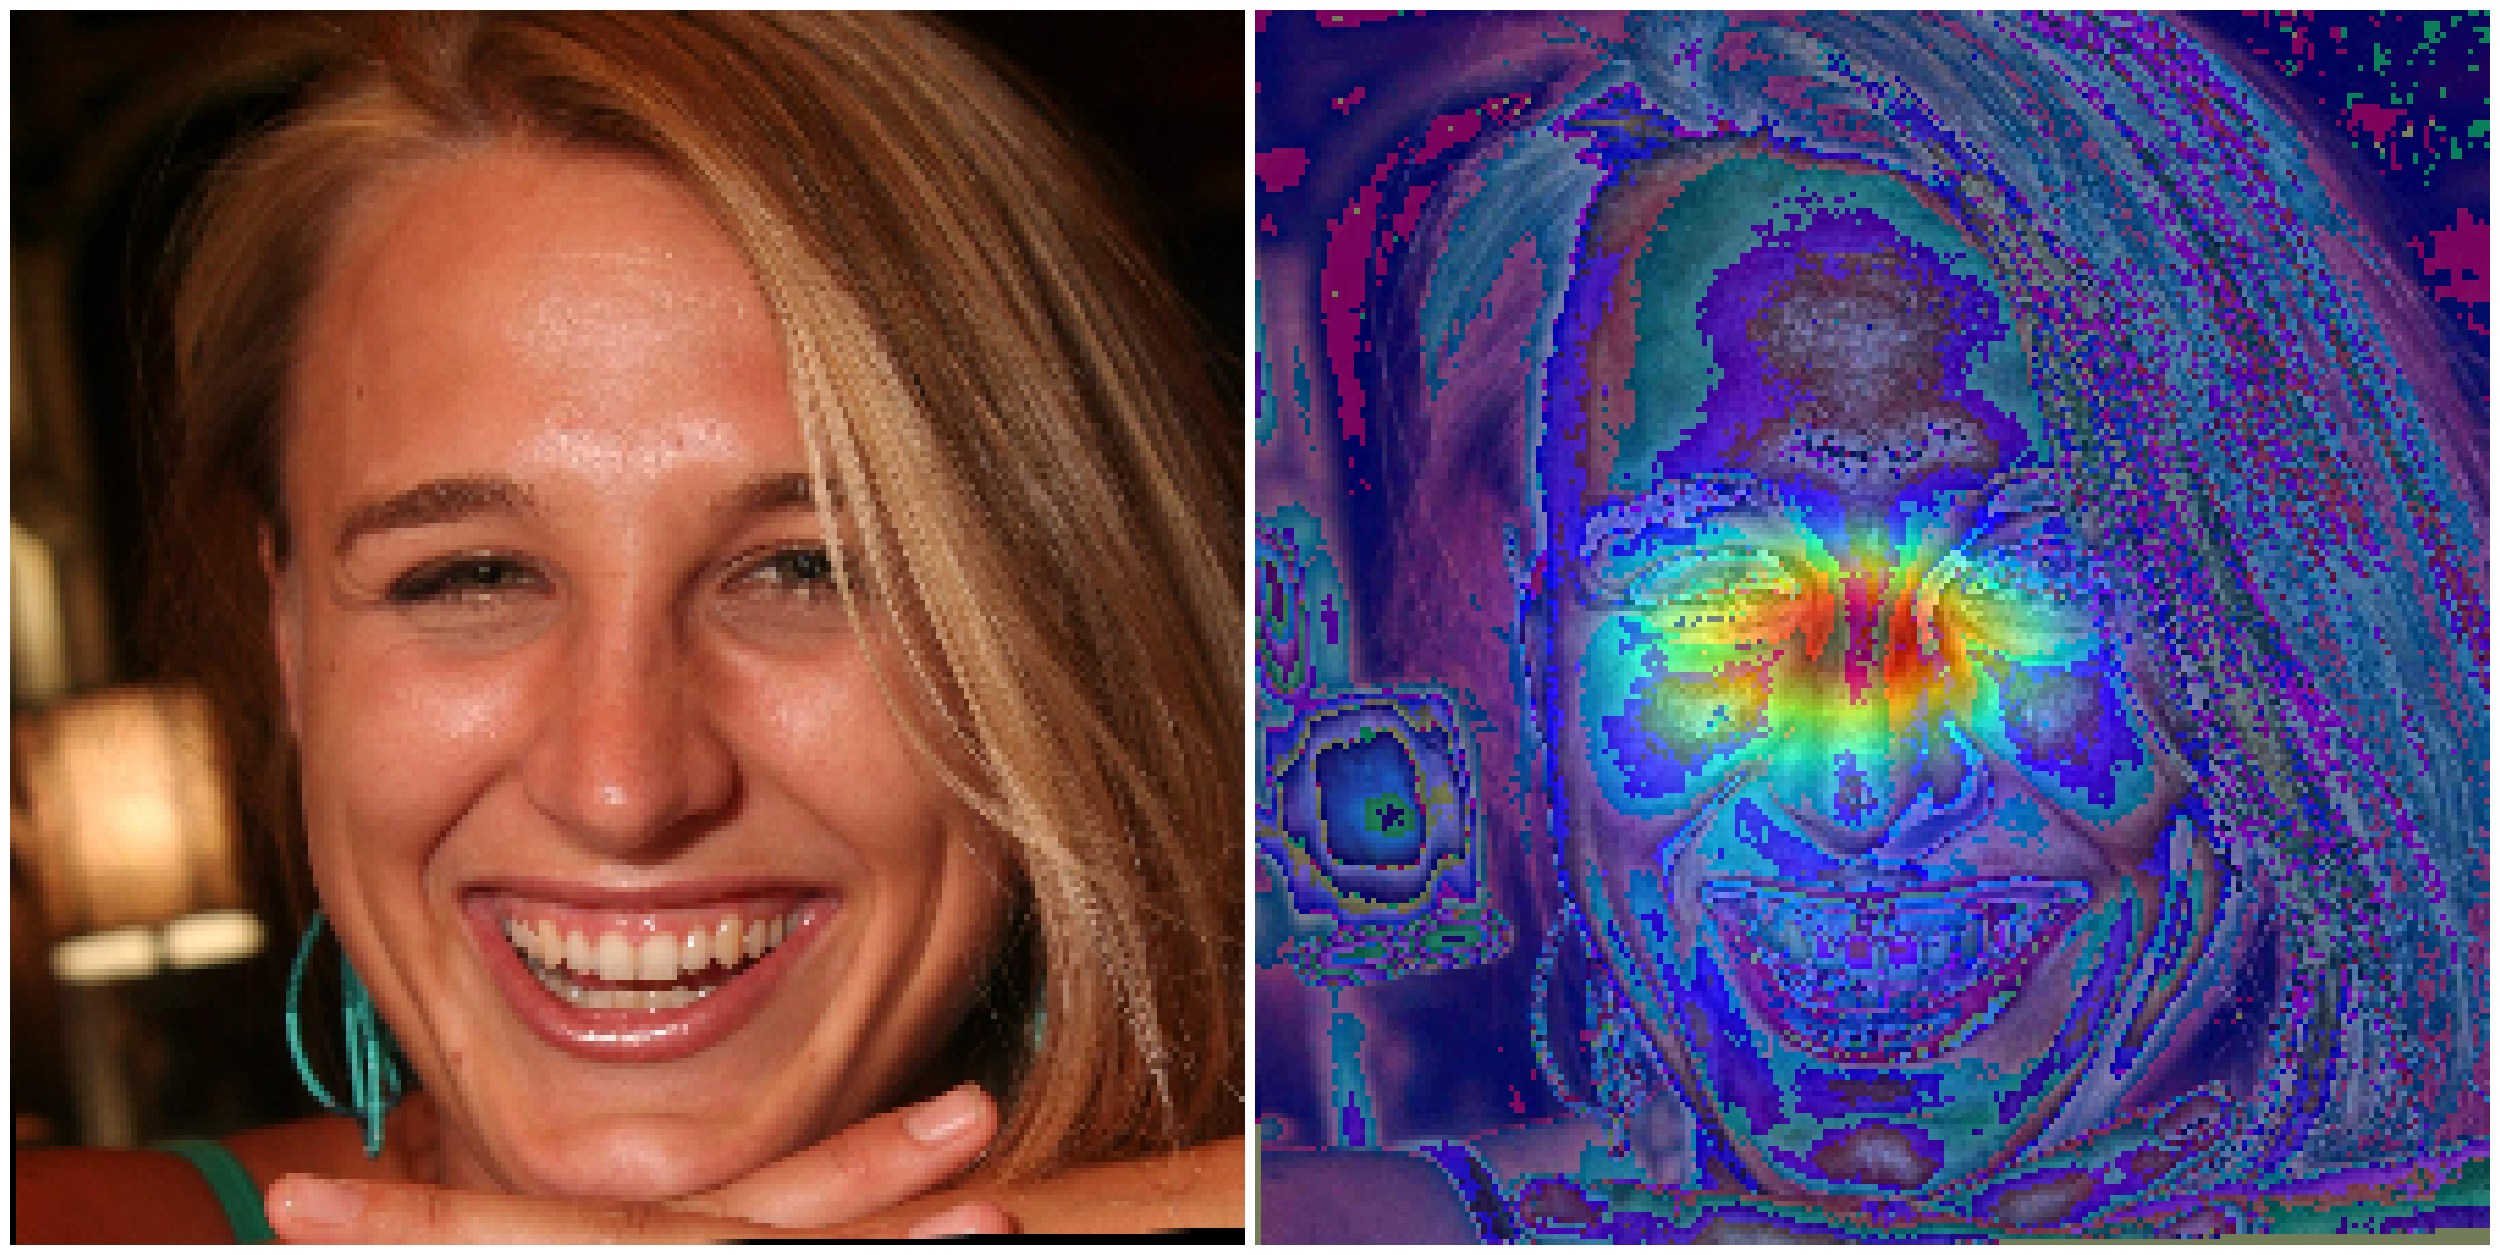

In [66]:
original_image = Image.open(img_path).convert('RGB')
overlayed_cam = cam

fig = plt.figure(figsize=(10., 8.), facecolor='white')
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 aspect=1.2
                 )

for index, (ax, im) in enumerate(zip(grid, [original_image, overlayed_cam])):
    # Iterating over the grid returns the Axes.
    ax.axis('off')
    ax.grid(b=None)
    ax.imshow(im)
    #ax.set_title(predictions[index], fontsize=45)
fig.set_size_inches(32, 18)
plt.show()

In [67]:
plt.savefig("../output/entropy-densenet-example.png", format='png', bbox_inches='tight', dpi = 500)

<Figure size 640x480 with 0 Axes>